In [1]:
# Author: Lee Yat Shun, Jasper
# Copyright (c) 2023 Lee Yat Shun, Jasper. All rights reserved.

In [2]:
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from caviar import CaviarModel
from backtesting import backtest
from var_tests import binomial_test, kupiec_pof_test, christoffersen_test

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_excel('../data/SPY.xlsx')
df.columns = df.iloc[5].values
df = df.iloc[6:].iloc[::-1].reset_index(drop=True)
df['Log Return'] = df.PX_LAST.apply(lambda x: np.log(x)).diff()
df = df.set_index('Date')
df.head()

,PX_LAST,Change,% Change,PX_OPEN,Change,% Change,PX_HIGH,Change,% Change,PX_LOW,Change,% Change,Log Return
Date,,,,,,,,,,,,,
1993-01-29,25.2238,NaN,NaN,25.2417,NaN,NaN,25.2417,NaN,NaN,25.1161,NaN,NaN,NaN
1993-02-01,25.4032,NaN,NaN,25.2417,NaN,NaN,25.4032,NaN,NaN,25.2417,NaN,NaN,0.007087
1993-02-02,25.457,NaN,NaN,25.3852,NaN,NaN,25.4749,NaN,NaN,25.3314,NaN,NaN,0.002116
1993-02-03,25.7261,NaN,NaN,25.4929,NaN,NaN,25.744,NaN,NaN,25.4749,NaN,NaN,0.010515
1993-02-04,25.8337,NaN,NaN,25.8158,NaN,NaN,25.8876,NaN,NaN,25.762,NaN,NaN,0.004174


In [5]:
returns = df['Log Return'].dropna()
low_open_log_difference = (df['PX_LOW'].apply(lambda x: np.log(x)) - df['PX_OPEN'].apply(lambda x: np.log(x))).dropna()

## Numeric

In [6]:
in_samples = returns[2000:-2000] * 100
out_of_samples = returns[-2000:] * 100

In [7]:
# initiate parameter
quantile = 0.05 # 5% VAR

In [8]:
# fitting process
caviar_model = CaviarModel(quantile, model='asymmetric', method='mle')
caviar_model.fit(in_samples)

Generating 5 best initial betas out of 5000...
Optimizing...
when m = 1
Update 0: 0.1402419353974551
Update 1: 0.1248156444290057
Update 2: 0.1248156437893875
Update 3: 0.1248156434333462
Update 4: 0.12481564341204765
when m = 2
Update 0: 0.15334333419424143
Update 1: 0.12480910843703381
Update 2: 0.124808953003413
Update 3: 0.12480895300341299
when m = 3
Update 0: 0.1538344959461404
Update 1: 0.12480845615867585
Update 2: 0.12480845615867588
when m = 4
Update 0: 0.15517959869020306
Update 1: 0.12480998032721595
Update 2: 0.1248089280565948
Update 3: 0.12480892606338136
Update 4: 0.124808920107286
Update 5: 0.12480892010728598
when m = 5
Update 0: 0.17356891286750756
Update 1: 0.12481603952389365
Update 2: 0.12481603183175434
Update 3: 0.12481603183175435
Final loss: 0.12480845615867585
Time taken(s): 28.60


In [9]:
print('S.E. of beta:', caviar_model.beta_standard_errors)
print('pval of beta:', caviar_model.beta_pvals)

S.E. of beta: [0.01185334 0.02465835 0.03764134 0.08181119]
pval of beta: [0.00066376 0.         0.42458159 0.00697981]


### Backtesting on the out of samples

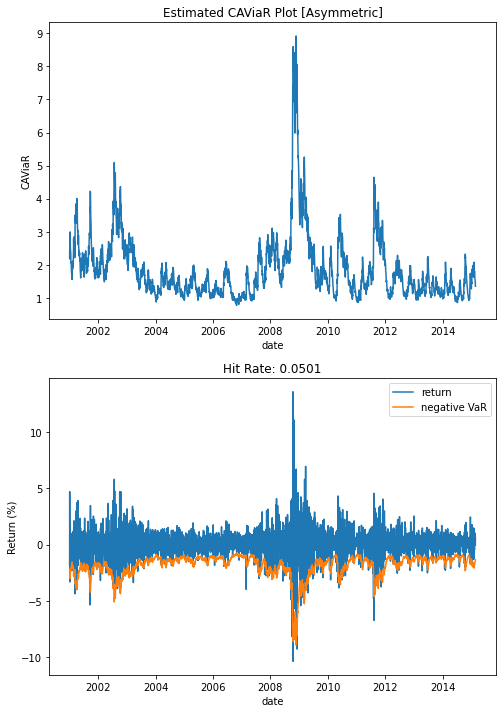

In [10]:
# in sample
caviar_model.plot_caviar(in_samples)

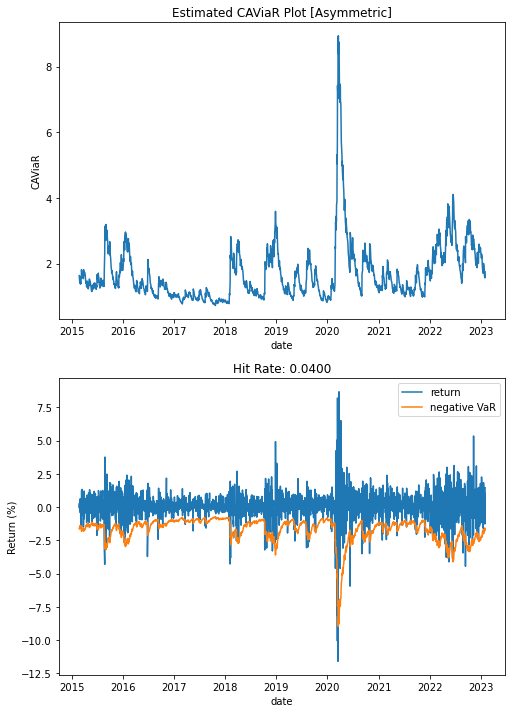

In [11]:
# out of sample
caviar_model.plot_caviar(out_of_samples)

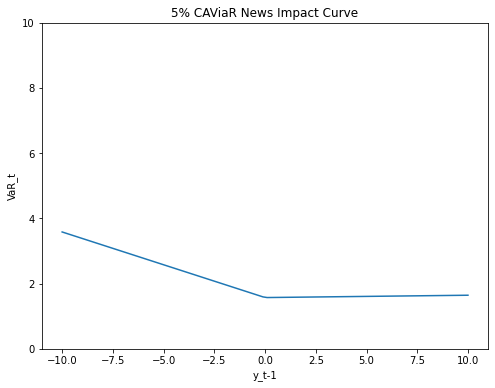

In [12]:
caviar_model.plot_news_impact_curve(VaR=-1.645)

In [13]:
# RQ loss
print(caviar_model.obj(caviar_model.beta, in_samples, caviar_model.quantile, caviar_model.caviar))
print(caviar_model.obj(caviar_model.beta, out_of_samples, caviar_model.quantile, caviar_model.caviar))

0.12480845615867585
0.12627704977575002


### VaR Test

In [14]:
in_VaR = caviar_model.predict(in_samples)

In [15]:
out_VaR = caviar_model.predict(out_of_samples)

In [16]:
# The null hypothesis states that the current VaR violations are uncorrelated with past violations.

print(caviar_model.dq_test(in_samples, 'in'))
print(caviar_model.dq_test(out_of_samples, 'out'))

0.3034176468763714
0.9997043652897051


In [17]:
# H0: the obs ~ binomial(p)

print(binomial_test(in_samples, in_VaR, caviar_model.quantile))
print(binomial_test(out_of_samples, out_VaR, caviar_model.quantile))

0.96930383635541
0.04001082220695236


In [18]:
# H0: the observed failure rate is equal to the failure rate suggested by the confidence interval.

print(kupiec_pof_test(in_samples, in_VaR, caviar_model.quantile))
print(kupiec_pof_test(out_of_samples, out_VaR, caviar_model.quantile))

1.0
1.0


In [19]:
# null hypothesis: the observations are independent of each other

print(christoffersen_test(in_samples, in_VaR))
print(christoffersen_test(out_of_samples, out_VaR))

0.5155453367851368
0.8575427441112737


### Backtesting

In [20]:
out_low_open_log_difference = low_open_log_difference.loc[out_of_samples.index]
(out_low_open_log_difference * 100 < out_VaR).value_counts(normalize=True)

False    0.9485
True     0.0515
dtype: float64

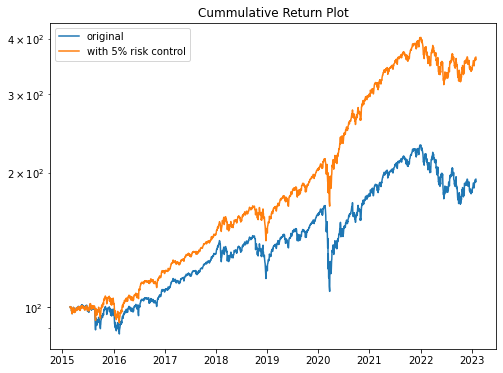

In [21]:
# with 0.2% transaction cost

backtest(out_of_samples, out_low_open_log_difference, out_VaR, caviar_model.quantile, ntl=100, penalty=0.002)

### Forecast

In [22]:
caviar_model.forecast(out_of_samples[-1], out_VaR[-1])

-1.6845735817415775